# 1. TRAINING:

In [ ]:
!pip install -q matplotlib datasets joblib


In [16]:
# Import necessary libraries
import joblib
from huggingface_hub import login, HfApi
from huggingface_hub import hf_hub_download
import os
from huggingface_hub import hf_hub_download
import joblib

# Get the token from environment variables
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

if not HUGGINGFACE_TOKEN:
    raise ValueError("HUGGINGFACE_TOKEN is not set in the environment variables.")


# Set your repository name
repo_name = "davnas/library_model"  # Replace with your desired repository name

## 1.1.Download Tables

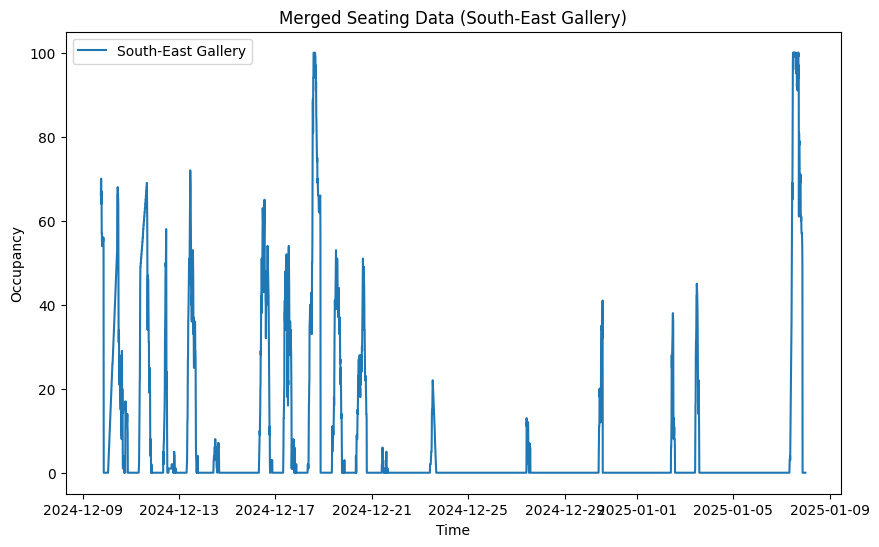

In [18]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta
# Step 1: Load the seating dataset
repo_name_seating = "davnas/occupancy_perc"
hf_dataset_seating = load_dataset(repo_name_seating)

# Combine all splits into a single DataFrame with appropriate data types
df_seating = pd.concat(
    [split.to_pandas().astype({'KTH Library': int, 'South-East Gallery': int, 'North Gallery': int,
                               'South Gallery': int, 'Ångdomen': int, 'Newton': int})
     for split in hf_dataset_seating.values()],
    ignore_index=True
)
df_seating.set_index('index', inplace=True)
df_seating.index = pd.to_datetime(df_seating.index)  # Ensure the index is datetime

# Resample to 10-minute intervals and fill missing data
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)
plt.figure(figsize=(10, 6))
plt.plot(df_seating_resampled.index, df_seating_resampled['South-East Gallery'], label="South-East Gallery")
plt.title("Merged Seating Data (South-East Gallery)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.show()

In [19]:
df_seating
#df_seating.to_csv('data.csv')

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
index,,,,,,
2024-12-09 18:16:16,35,66,60,17,21,22
2024-12-09 18:19:24,34,66,59,14,19,22
2024-12-09 18:22:31,32,69,59,17,18,22
2024-12-09 18:25:37,29,66,56,26,19,22
2024-12-09 18:28:44,29,71,56,26,19,17
...,...,...,...,...,...,...
2025-01-07 23:39:52,0,0,0,0,0,0
2025-01-07 23:43:05,0,0,0,0,0,0
2025-01-07 23:46:17,0,0,0,0,0,0


In [20]:
# Step 2: Load the academic calendar dataset
repo_name_calendar = "andreitut/kth-academic-scraper"
hf_dataset_calendar = load_dataset(repo_name_calendar)

# Convert the calendar dataset to a DataFrame
df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])

# Expand the calendar dataset to match the minute-level resolution
df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
4206,2025-01-07,2025,7,2,0,Exam
4207,2025-01-07,2025,7,2,0,Exam
4208,2025-01-07,2025,7,2,0,Exam
4209,2025-01-07,2025,7,2,0,Exam


In [21]:
# Step 4: Load the historical weather data from Hugging Face
repo_name_weather = "andreitut/weatherDatasetProject"
hf_dataset_weather = load_dataset(repo_name_weather)
df_weather = pd.concat([split.to_pandas() for split in hf_dataset_weather.values()], ignore_index=True)
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather.set_index('time', inplace=True)
df_weather

,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2024-01-02 00:00:00,-4.0,0.1,16.6,85.0
2024-01-02 01:00:00,-4.0,0.2,17.2,79.0
2024-01-02 02:00:00,-4.4,0.2,17.0,84.0
2024-01-02 03:00:00,-4.6,0.2,17.3,86.0
2024-01-02 04:00:00,-4.8,0.1,18.8,86.0
...,...,...,...,...
2025-01-07 19:00:00,NaN,NaN,NaN,NaN
2025-01-07 20:00:00,NaN,NaN,NaN,NaN
2025-01-07 21:00:00,NaN,NaN,NaN,NaN


In [22]:
repo_name = "davnas/date_kth"

# Load the dataset from Hugging Face
hf_dataset = load_dataset(repo_name)

df_opening = pd.concat(
    [split.to_pandas() for split in hf_dataset.values()],
    ignore_index=True
)

# Set the index if the 'index' column exists
if 'index' in df_opening.columns:
    df_opening.set_index('index', inplace=True)

# Display the DataFrame
print(df_opening)


          date        day  opening_hour  closing_hour  is_open
0   2024-12-09     Monday            18            21        1
1   2024-12-10    Tuesday            10            21        1
2   2024-12-11  Wednesday             8            21        1
3   2024-12-12   Thursday             8            21        1
4   2024-12-13     Friday             8            18        1
5   2024-12-14   Saturday             0             0        0
6   2024-12-15     Sunday             0             0        0
7   2024-12-16     Monday            10            21        1
8   2024-12-17    Tuesday            10            21        1
9   2024-12-18  Wednesday             8            21        1
10  2024-12-19   Thursday             8            21        1
11  2024-12-20     Friday             8            19        1
12  2024-12-21   Saturday             0             0        0
13  2024-12-22     Sunday             0             0        0
14  2024-12-23     Monday            10            14  

 ## 1.2. MERGING Tables


In [23]:
# Step 3: Merge the seating data with the expanded academic calendar
merged_seating_calendar = pd.merge_asof(
    df_seating_resampled.sort_index(),
    df_calendar_expanded.sort_values('Date'),
    left_index=True,
    right_on='Date'
)
# Visualize Step 3: Merged seating and calendar data
print("Step 3: Merged seating data with academic calendar")

merged_seating_calendar

Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
index,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:20:00,29,70,57,24,19,19,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:30:00,28,70,55,26,14,11,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:40:00,24,64,55,25,15,17,2024-12-09,2024,344,1,29,Normal
2024-12-09 18:50:00,22,67,45,26,14,13,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:20:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam
2025-01-07 23:30:00,0,0,0,0,0,0,2025-01-07,2025,7,2,0,Exam


In [24]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    df_weather.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
index,,,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:20:00,29,70,57,24,19,19,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:30:00,28,70,55,26,14,11,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:40:00,24,64,55,25,15,17,344,1,29,Normal,-0.4,0.0,6.3,325.0
2024-12-09 18:50:00,22,67,45,26,14,13,344,1,29,Normal,-0.4,0.0,6.3,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-07 23:20:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN
2025-01-07 23:30:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN


In [25]:
# Convert the 'date' column in df_opening to datetime to match the index of merge_seat_academic_weather
df_opening['date'] = pd.to_datetime(df_opening['date'])

# Merge on the date index while ensuring time-specific data aligns properly
merged_final = pd.merge_asof(
    merge_seat_academic_weather.reset_index(),
    df_opening,
    left_on='index',
    right_on='date',
    direction='backward'
).set_index('index')

# Drop unnecessary columns if needed (like duplicate 'date' column)
merged_final.drop(columns=['date'], inplace=True)

# Display the resulting DataFrame
print(merged_final)
merged_final.to_csv('merged_final.csv')

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2024-12-09 18:10:00           34                  66             60   
2024-12-09 18:20:00           29                  70             57   
2024-12-09 18:30:00           28                  70             55   
2024-12-09 18:40:00           24                  64             55   
2024-12-09 18:50:00           22                  67             45   
...                          ...                 ...            ...   
2025-01-07 23:10:00            0                   0              0   
2025-01-07 23:20:00            0                   0              0   
2025-01-07 23:30:00            0                   0              0   
2025-01-07 23:40:00            0                   0              0   
2025-01-07 23:50:00            0                   0              0   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

In [26]:
if 'opening_hour' in merged_final.columns and 'closing_hour' in merged_final.columns:
    merged_final['is_open'] = (
        (merged_final.index.hour >= merged_final['opening_hour']) &
        (merged_final.index.hour < merged_final['closing_hour'])
    ).astype(int)

merged_final

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,day,opening_hour,closing_hour,is_open
index,,,,,,,,,,,,,,,,,,
2024-12-09 18:10:00,34,66,60,16,20,22,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:20:00,29,70,57,24,19,19,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:30:00,28,70,55,26,14,11,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:40:00,24,64,55,25,15,17,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
2024-12-09 18:50:00,22,67,45,26,14,13,344,1,29,Normal,-0.4,0.0,6.3,325.0,Monday,18,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-07 23:10:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0
2025-01-07 23:20:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0
2025-01-07 23:30:00,0,0,0,0,0,0,7,2,0,Exam,NaN,NaN,NaN,NaN,Tuesday,8,21,0


In [27]:
from datetime import datetime, timedelta

# 1. Ensure the index is a DatetimeIndex
if not isinstance(merged_final.index, pd.DatetimeIndex):
    merged_final.index = pd.to_datetime(merged_final.index)

# 2. Calculate the filter date (2 days ago)
filter_date = datetime.now() - timedelta(days=2)

# 3. Filter the DataFrame for entries before the filter date
df_prophet = merged_final[merged_final.index < filter_date].copy()  # Copy ensures no views
df = df_prophet.copy()
df.columns
df.tail()

df_merged = df.copy()

## 2. XGBOOST NO ROLLING

In [28]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [29]:
# ----------------------
# Model Training
# ----------------------

from utils import prepare_model_features 
from utils import add_time_features
from utils import preprocess_raw_data
def train_location_model(df_train, location, model_params=None):
    """
    Train model for a specific location.

    Args:
        df_train: Training DataFrame
        location: Name of the location column
        model_params: XGBoost parameters (optional)
    Returns:
        Trained model and training metrics
    """
    # Default model parameters if none provided
    if model_params is None:
        model_params = {
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'random_state': 42
        }

    # Prepare features and target
    X = prepare_model_features(df_train)
    y = df_train[location]

    # Train model
    model = XGBRegressor(**model_params)
    model.fit(X, y)

    # Get training predictions and metrics
    train_pred = model.predict(X)
    train_metrics = calculate_metrics(y, train_pred)

    return model, train_metrics


In [30]:
# ----------------------
# Prediction & Evaluation
# ----------------------

def make_predictions(model, df):
    """
    Make predictions using trained model.
    """
    X = prepare_model_features(df)
    predictions = model.predict(X)

    # Set predictions to 0 when location is closed
    predictions[df['is_open'] == 0] = 0

    return predictions

def calculate_metrics(actual, predicted):
    """
    Calculate model performance metrics.
    """
    return {
        'mae': mean_absolute_error(actual, predicted),
        'rmse': np.sqrt(mean_squared_error(actual, predicted))
    }

def plot_occupancy(dates, predictions, actual=None, location=""):
    """
    Plot predicted (and actual if available) occupancy.
    """
    plt.figure(figsize=(12, 6))

    if actual is not None:
        plt.plot(dates, actual, label="Actual", color="orange", alpha=0.7)
        title = f"Actual vs Predicted Occupancy - {location}"
    else:
        title = f"Predicted Occupancy - {location}"

    plt.plot(dates, predictions, label="Predicted", color="blue", alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Occupancy")
    plt.title(title)
    plt.legend()
    plt.show()

In [31]:
# ----------------------
# Main Pipeline Functions
# ----------------------

def train_all_locations(df, locations, split_date):
    """
    Train models for multiple locations.

    Args:
        df: Input DataFrame
        locations: List of location columns
        split_date: Date to split train/test data
    Returns:
        Dictionary with models and metrics for each location
    """
    results = {}

    # Split data
    df_train = df[df.index < split_date]
    df_test = df[df.index >= split_date]

    for location in locations:
        print(f"\nTraining model for {location}")

        # Train model
        model, train_metrics = train_location_model(df_train, location)

        # Test model
        test_pred = make_predictions(model, df_test)
        test_metrics = calculate_metrics(df_test[location], test_pred)

        # Store results
        results[location] = {
            'model': model,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }

        # Plot results
        plot_occupancy(df_test.index, test_pred, df_test[location], location)

        # Print metrics
        print(f"Training MAE: {train_metrics['mae']:.2f}")
        print(f"Test MAE: {test_metrics['mae']:.2f}")

    return results

def predict_future(models_dict, future_df):
    """
    Make future predictions for all locations.

    Args:
        models_dict: Dictionary of trained models
        future_df: DataFrame with future data
    Returns:
        DataFrame with predictions for all locations
    """
    results_df = future_df.copy()

    for location, model_info in models_dict.items():
        predictions = make_predictions(model_info['model'], future_df)
        results_df[f'{location}_predicted'] = predictions

        # Plot predictions
        plot_occupancy(future_df.index, predictions, location=location)

    return results_df

In [32]:
def save_models_locally(models_dict, base_path=""):
    """
    Save trained models to local files.

    Args:
        models_dict: Dictionary containing trained models
        base_path: Path where to save the models
    Returns:
        dict: Dictionary mapping locations to their model filenames
    """
    saved_files = {}

    for location, model_info in models_dict.items():
        # Create filename
        filename = f"xgboost_model_{location.replace(' ', '_')}.joblib"
        full_path = f"{base_path}{filename}"

        # Save model
        joblib.dump(model_info['model'], full_path)
        saved_files[location] = filename
        print(f"Model for {location} saved as {filename}")

    return saved_files

def upload_models_to_huggingface(saved_files, repo_name, token):
    """
    Upload saved models to Hugging Face.

    Args:
        saved_files: Dictionary mapping locations to model filenames
        repo_name: Name of the Hugging Face repository
        token: Hugging Face API token
    """
    # Login to Hugging Face
    login(token=token)

    # Initialize Hugging Face API
    api = HfApi()

    # Create or get repository
    api.create_repo(repo_id=repo_name, exist_ok=True, private=True)

    # Upload each model file
    for location, filename in saved_files.items():
        api.upload_file(
            path_or_fileobj=filename,
            path_in_repo=filename,
            repo_id=repo_name
        )
        print(f"Model for {location} uploaded as {filename}")

    print("All models uploaded successfully!")

def load_models_from_huggingface(locations, repo_name, token):
    """
    Load models from Hugging Face.

    Args:
        locations: List of locations
        repo_name: Name of the Hugging Face repository
        token: Hugging Face API token
    Returns:
        dict: Dictionary containing loaded models
    """
    login(token=token)
    loaded_models = {}

    for location in locations:
        filename = f"xgboost_model_{location.replace(' ', '_')}.joblib"

        # Download the model file
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=filename,
            token=token
        )

        # Load the model
        model = joblib.load(model_path)
        loaded_models[location] = {'model': model}
        print(f"Model for {location} loaded successfully")

    return loaded_models


Training model for KTH Library


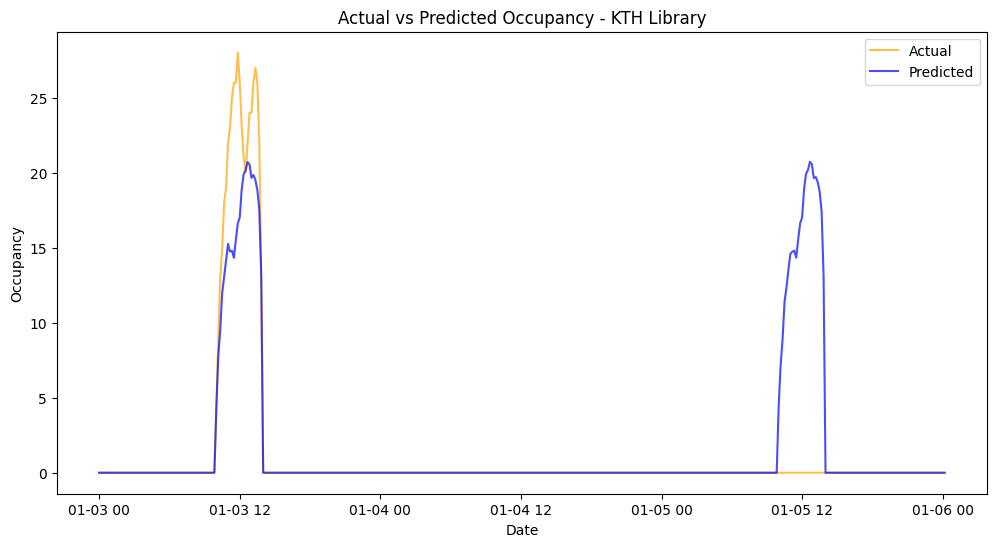

Training MAE: 0.40
Test MAE: 1.15

Training model for South-East Gallery


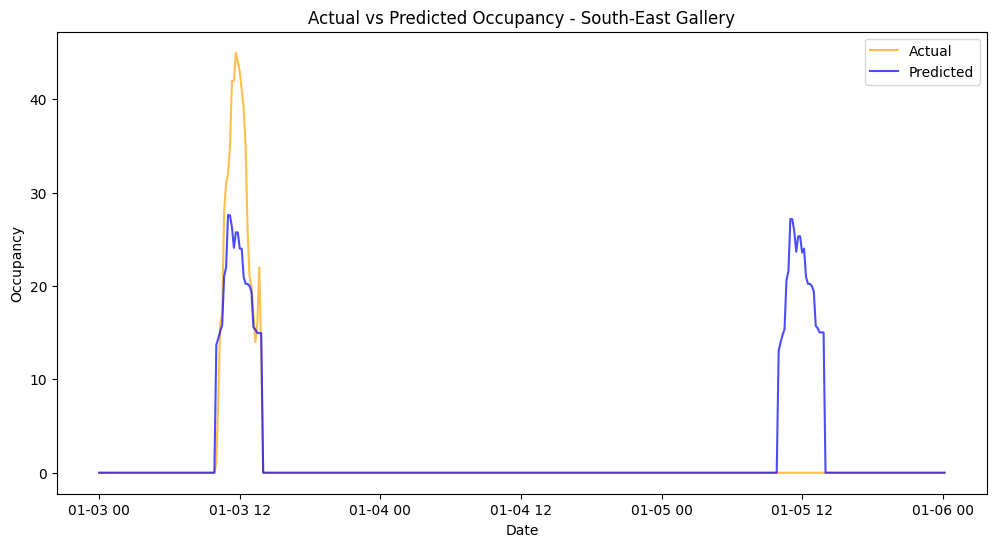

Training MAE: 0.69
Test MAE: 1.58

Training model for North Gallery


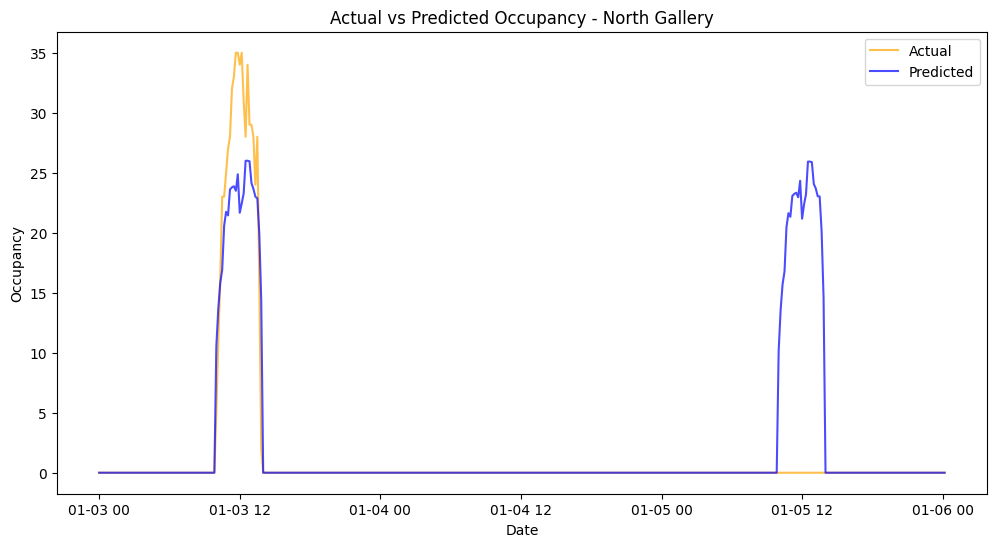

Training MAE: 0.69
Test MAE: 1.51

Training model for South Gallery


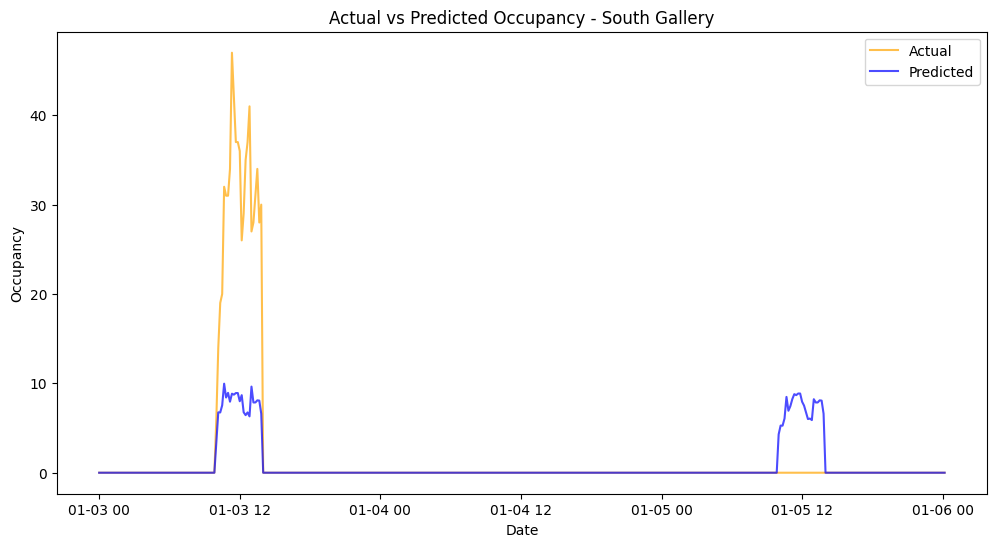

Training MAE: 0.69
Test MAE: 1.66

Training model for Ångdomen


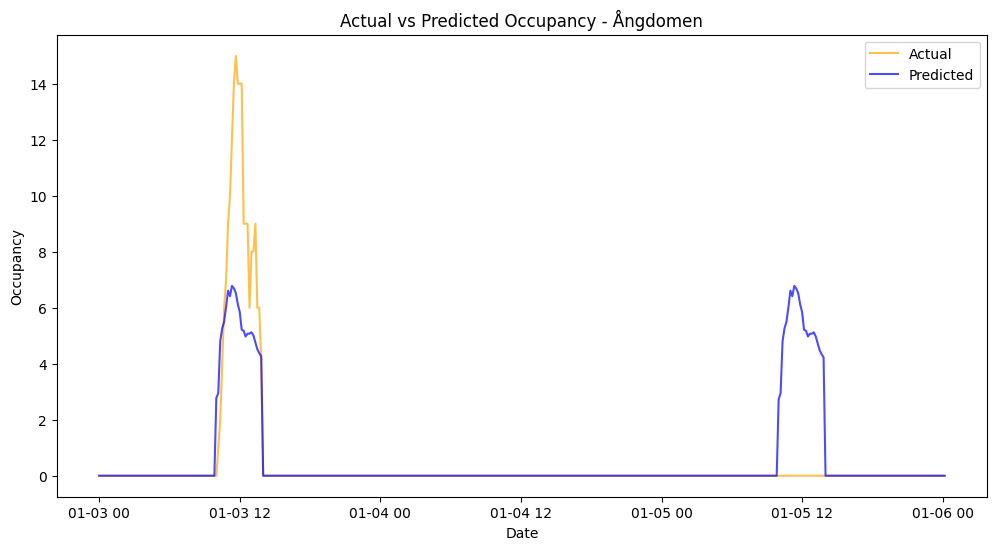

Training MAE: 0.21
Test MAE: 0.49

Training model for Newton


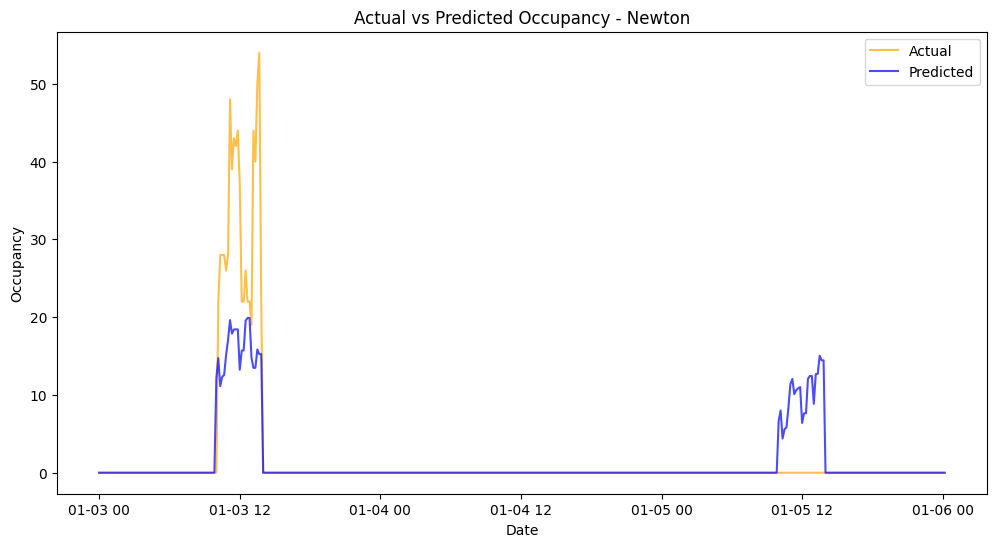

Training MAE: 0.84
Test MAE: 1.48


In [33]:
# Prepare your data
df = df_merged.copy()
df = preprocess_raw_data(df)

# Define locations and split date
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery',
       'Ångdomen', 'Newton']  # Add all your locations
split_date = '2025-01-3'

# Train models for all locations
trained_models = train_all_locations(df, locations, split_date)

In [34]:
# Save models locally
saved_files = save_models_locally(trained_models)

# Upload to Hugging Face
repo_name = "davnas/library_model"

# uncomment to upload the models to Hugging Face
#upload_models_to_huggingface(saved_files, repo_name, HUGGINGFACE_TOKEN)

Model for KTH Library saved as xgboost_model_KTH_Library.joblib
Model for South-East Gallery saved as xgboost_model_South-East_Gallery.joblib
Model for North Gallery saved as xgboost_model_North_Gallery.joblib
Model for South Gallery saved as xgboost_model_South_Gallery.joblib
Model for Ångdomen saved as xgboost_model_Ångdomen.joblib
Model for Newton saved as xgboost_model_Newton.joblib
